In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn 
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, confusion_matrix

import joblib


import warnings
warnings.filterwarnings('ignore')


In [394]:
data = pd.read_csv('API/df_pricing.csv')
data.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
2,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
3,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
4,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,131


In [395]:
data.shape

(4709, 14)

In [396]:
list=['Mini','Mazda','Honda','Lexus','Alfa Romeo']
for i in range(len(list)) : 
    data.drop(data[(data['model_key'] ==list[i])].index,axis=0,inplace=True)

In [397]:
data.dropna(inplace=True)

In [398]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "rental_price_per_day"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    106
1    101
2    158
3    183
4    131
Name: rental_price_per_day, dtype: int64

X :
  model_key  mileage  engine_power    fuel paint_color     car_type  \
0   Citroën   140411           100  diesel       black  convertible   
1   Citroën   183297           120  diesel       white  convertible   
2   Citroën   128035           135  diesel         red  convertible   
3   Citroën    97097           160  diesel      silver  convertible   
4   Citroën   152352           225  petrol       black  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
1                      False    False                 False          False   
2                       True     True                 False          False   
3                       True     True                 False          False   
4                       True     True     

In [358]:
unvalid_models = ['Suzuki', 'Porsche', 'Ford', 'KIA Motors', 'Alfa Romeo', 'Fiat', 'Lexus', 'Lamborghini', 'Mini', 'Mazda', 'Honda', 'Yamaha']

In [359]:
to_drop = data['model_key'].isin(unvalid_models)
data = data[~to_drop]

In [400]:
#drop missing values
data = data.dropna()

In [401]:
data.shape

(4704, 14)

In [402]:
features_list = data.columns[:-1].tolist()
target_variable = 'rental_price_per_day'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

In [403]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [404]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['mileage', 'engine_power']
Found categorical features  ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


In [405]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

---

Let's start with a basic linear regression model and work our way up to a more complex model.

In [325]:
linear = LinearRegression()
linear.fit(X_train, Y_train)

train_pred = linear.predict(X_train)
test_pred = linear.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.7264306632142536
f1-score on test set :  0.6444696231873723


### Biggest contributors to the model

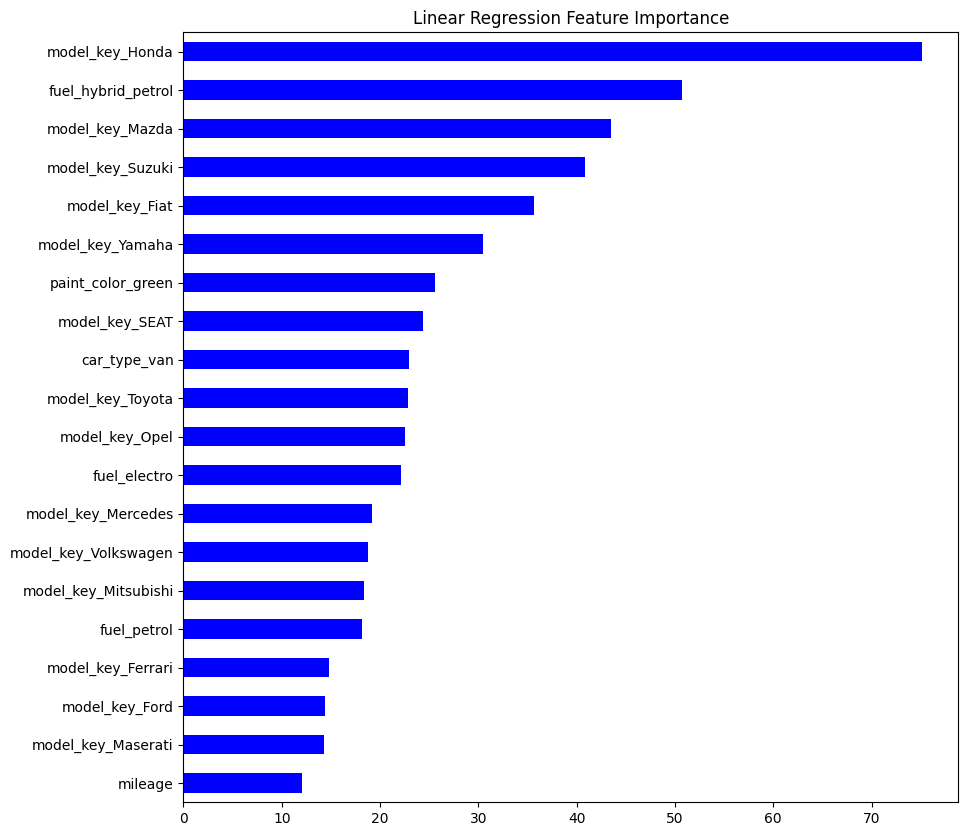

In [326]:
col_names = (preprocessor.transformers_[0][1].get_feature_names_out()).tolist() + (preprocessor.transformers_[1][1].get_feature_names_out()).tolist()
feat_importances = pd.Series(np.abs(linear.coef_), index=col_names).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh', color='blue')
plt.title('Linear Regression Feature Importance')
plt.show() 

---

## Gradient Boosting Regressor


Let's perform a grid search to find the best parameters for our model.

In [146]:
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor()
params = {
    'learning_rate': [0.1,0.05,0.2],
    'max_leaf_nodes': [20,30,40,50,60],
    'max_depth' : [6,8,10,12,16],
    'min_samples_leaf' : [2,4,6,8,10],
    'n_estimators' : [75,100,125,150]
}

gridsearch = GridSearchCV(gbr, param_grid = params, n_jobs=-1, cv = 7,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.783232 using {'learning_rate': 0.1, 'max_depth': 12, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'n_estimators': 150}


In [327]:
gbr = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 12, max_leaf_nodes= 30, min_samples_leaf= 2, n_estimators= 150)
gbr.fit(X_train, Y_train)

train_pred = gbr.predict(X_train)
test_pred = gbr.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.9194932930505384
f1-score on test set :  0.7403158806097809


We have a better score with XGBoost compared to the linear regression model. That's because XGBoost is a more complex model. it relies on a gradient descent algorithm to minimize the loss function. It is a greedy algorithm that builds the model in a stage-wise fashion. It builds the model in a stage-wise fashion like other boosting algorithms do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

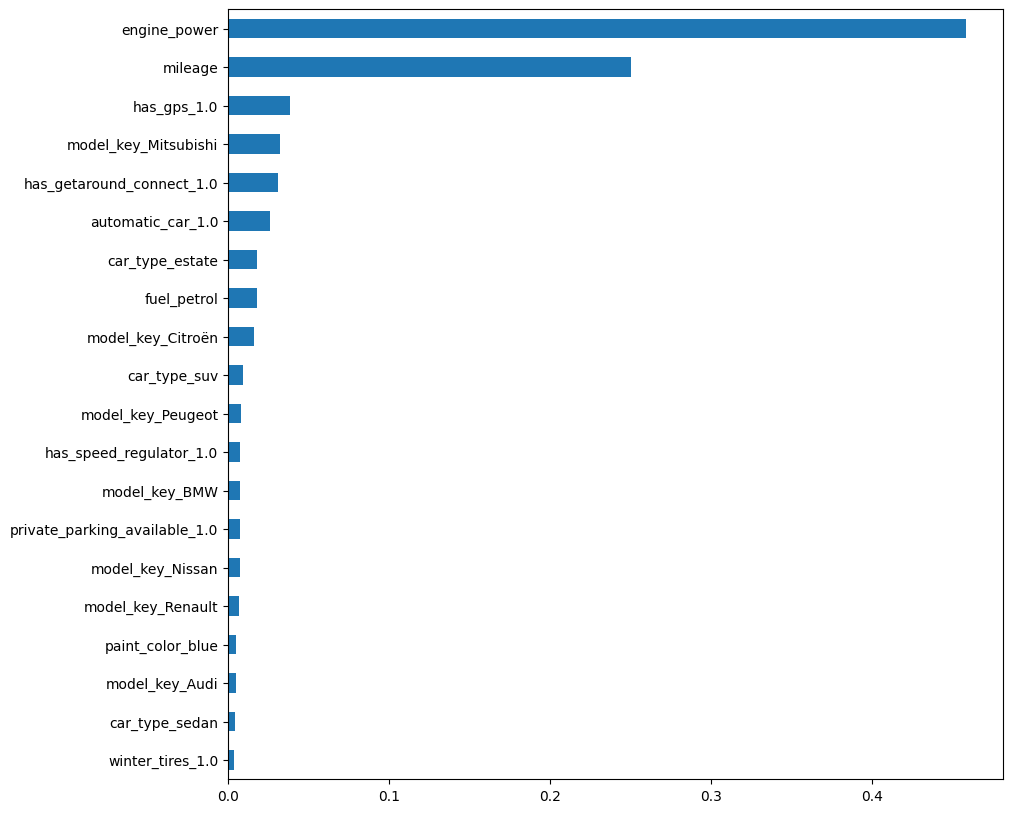

In [328]:
col_names = (preprocessor.transformers_[0][1].get_feature_names_out()).tolist() + (preprocessor.transformers_[1][1].get_feature_names_out()).tolist()
feat_importances = pd.Series(gbr.feature_importances_, index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show()

Strong reliance of the model on the engine power, then mileage and if the car has GPS or not respectively

In [ ]:
model = Pipeline(steps=[
        ("Preprocessing", preprocessor),
        ("Regressor",XGBRegressor(learning_rate= 0.1, max_depth= 12, max_leaf_nodes= 30, min_samples_leaf= 2, n_estimators= 150))
    ])

In [ ]:
model.fit(X_train, Y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("r2 on train set : ", r2_score(Y_train, train_pred))
print("r2 on test set : ", r2_score(Y_test, test_pred))

r2 on train set :  0.9049035198876252
r2 on test set :  0.7556533641207392


In [ ]:
from joblib import dump, load
dump(model, 'API/gbr_model.joblib')

['API/gbr_model.joblib']

In [ ]:
data = pd.DataFrame(dict(predictionFeatures), index=[0])
data

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Peugeot,14699,100,diesel,black,sedan,False,True,False,False,False,True,True


In [ ]:
prediction = model.predict(data)
response = {"predictions": prediction.tolist()[0]}

In [ ]:
response

{'predictions': 137.42332458496094}

# Setting up an API

In [329]:
joblib.dump(gbr,'API/gbr_model.pkl')
joblib.dump(preprocessor,'API/preprocessor.pkl')

['API/preprocessor.pkl']

In [338]:
from joblib import dump, load
dump(gbr, 'API/gbr_model.joblib')

['API/preprocessor.joblib']

In [330]:
predictionFeatures = {
                        "model_key" : "Peugeot",
                        "mileage" : 14699,
                        "engine_power" : 100,
                        "fuel" : "diesel",
                        "paint_color" : "black",
                        "car_type" : "sedan",
                        "private_parking_available" : False,
                        "has_gps" : True,
                        "has_air_conditioning" : False,
                        "automatic_car" : False,
                        "has_getaround_connect" : False,
                        "has_speed_regulator" : True,
                        "winter_tires" : True
                        }

In [ ]:
append_list = []
for key in predictionFeatures.keys():
    append_list.append(key)
    
print(append_list)

values_list = []
for key in predictionFeatures.values():
    values_list.append(key)
    
print(values_list)

['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
['Peugeot', 14699, 100, 'diesel', 'black', 'sedan', False, True, False, False, False, True, True]


In [331]:
input_df = pd.DataFrame(columns=[append_list])
input_df.loc[0,:] = values_list

In [332]:
input_df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Peugeot,14699,100,diesel,black,sedan,False,True,False,False,False,True,True


In [333]:
X = input_df
X = preprocessor.transform(X)

pred = gbr.predict(X)
print('Prediction for rental price per day : ', pred[0],'$')

Prediction for rental price per day :  141.77444178009154 $


The Pipeline of the API seems to be working, let's build the API.

In [335]:
import requests

In [341]:
url = 'http://localhost:4000/predict'

In [ ]:
response = requests.post(url,
    json={
        "model_key" : "Peugeot",
        "mileage" : 14699,
        "engine_power" : 100,
        "fuel" : "diesel",
        "paint_color" : "black",
        "car_type" : "sedan",
        "private_parking_available" : False,
        "has_gps" : True,
        "has_air_conditioning" : False,
        "automatic_car" : False,
        "has_getaround_connect" : False,
        "has_speed_regulator" : True,
        "winter_tires" : True
        })

print(response.json())

Prediction for rental price per day :  141.77444178009154 $


the API works locally, let's deploy it on Heroku !